In [1]:
#!pip uninstall visualkeras

In [2]:
#!pip install scikit-learn

In [3]:
#!pip install tensorflow-gpu

In [4]:
#!pip install pandas

In [5]:
#!pip install wandb

In [6]:
#!pip install numpy

In [7]:
#!pip install openpyxl

In [1]:
#Manejo de Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Librerias estandar (Extras)
import re
import os
import time
import random
from datetime import datetime

In [2]:
"""
DIRECTORIOS DEL PROYECTO
"""
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis'   # Directorio del proyecto
path_imagenes = 'F:/GOES/'                                         # Directorio de las imagenes procesadas
listDataset = [f'{path_base}/Archivos/Dataset/datasetMuestra.csv']          # Directorio(s) de los datos de precipitacion

In [3]:
!python --version
print(tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Limitamos el GPU, en caso se necesite
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

Python 3.9.11
2.8.0
Num GPUs Available:  1


In [4]:
#conda list cudnn

In [5]:
#conda list cudatoolkit

In [6]:
"""
Metodos para realizar el entrenamient - evaluacion del modelo
"""

'\nMetodos para realizar el entrenamient - evaluacion del modelo\n'

In [7]:

#Lee el archivo "filename" de datos de precipitacion y
#regresa un df que facilite la lectura del dataset para el entrenmaiento
def obtenerDatos(filename):
    start_time = time.time()
    pdata = pd.read_csv(filename)
    
    # Quitamos los valores NA
    pdata = pdata[pdata['dato'].notna()]

    # Definimos un solo tipo (str) pora asi poder convertirlo a tensor
    pdata = pdata.astype({"dato": str, "XO": str, "XA": str, "fecha": str})

    #Definimos la nueva columna para guardar el XO, XA y fecha
    pdata['imagen'] = pdata.apply(obtenerDir, axis=1)

    # Seleccionamos solo las columnas necesarias :
    # precipitacion, Estacion (Longitud), Estacion (Latitud), Fecha (año-mes-dia-hora)
    #pdataX = pdata.loc[:, ['dato','umbral','altura', 'imagen', 'fecha']]
    pdata = pdata.astype({"dato": str, "umbral": str, "altura": str, "imagen": str, "fecha": str})

    # Barajeamos los datos
    pdata = shuffle(pdata)

    print(f'{len(pdata)} datos leidos')
    print("Tiempo tomado en leer datos: %.2fs" % (time.time() - start_time))
    return pdata

In [8]:

# Devuelve una lista con lo indices que no se encontraron lso archivos y el producto
# Servira para ver si se teinen todas los frames de la fecha
def comprobarFrames(dfOrignial, path_base, products, times, delete=1):
    
    #dfOrignial = obtenerDatos(datafile)
    
    
    start_time = time.time()
    
    dfTotal = pd.unique(dfOrignial['fecha'])
    no_fecha = []
    for fecha in dfTotal:
        year, month, day, hour = fecha.split('-')
        existe = True
        for p in products:
            for t in range(len(times)):             
                filename = f'{path_base}PNG/{fecha}/{fecha}_{t}.png'
                try:                    
                    file_size = os.path.getsize(filename)
                    existe = file_size > 4100000
                except: 
                    existe = False
                    break
                
            if not existe:
                break
        if not existe:
            no_fecha.append(fecha)
            

    if delete:
        antes = len(dfOrignial)
        df2 = dfOrignial[~dfOrignial['fecha'].isin(no_fecha)]
        despues = len(df2)
        print(f'{antes - despues}/{antes} datos eliminados: No se encontraron los archivos de imagenes satelitales')
    else:
        df2 = dfOrignial

    print("Tiempo tomado en verificar datos: %.2fs" % (time.time() - start_time))
    return df2, no_fecha

In [9]:
#Del dataset guardamos los datos mas importantes en una columna para facilitar su lectura
def obtenerDir(row):
    fecha = row['fecha']

    year, month, day, hour = fecha.split('-')
    # filename = f'{path_base}comprimido/{year}_{month}_{day}/{hour}/'
    return f"{row['XO']}--{row['XA']}--{fecha}"

In [10]:
def limpiarDatos(listNames, path_imagenes, products, times ,ceros = 0.0 ,delete=1):
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    for name in listNames:
        try:
            df.append(pd.read_csv(name))   
        except:
            print(f'No se pudo leer el archivo {name} de dataset')
            return -1
        
    if len(df)>2:
        dsCompleto =  pd.concat(df, ignore_index=True) 
    else:
        dsCompleto =  df[0]
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    dsCompleto = dsCompleto[dsCompleto['flag'].isin(['C0000001','C0000002'])]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
              
    
    # Buscamos imagenes satelitales para lso archivos
    print(f'\nSe buscara las imagenes satelitales para los datos...')
    dfImagenes, no_fecha = comprobarFrames(dsCompleto, path_imagenes, products, times, delete)    
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
       
        
        
    #Limitamos la cantidad de ceros
    if ceros:
        print(f'\nSe limitara el numero de ceros al {ceros*100:.2f} porciento...')
        dsNoNulo = dfImagenes[dfImagenes['dato']!=0]
        dsNulo = dfImagenes[dfImagenes['dato']==0]
        dsNulo = dsNulo.sample(n=int(ceros*len(dsNoNulo)))        
        dfImagenes = pd.concat([dsNoNulo,dsNulo], ignore_index=True) 
        print(f'+Cantidad de datos luego de limtar ceros {len(dfImagenes)}')
    
    #Agregamos lso datos de las estaciones al dataset
    print(f'\nSe agregara los datos de las estaciones(cordenadas, umbral)...')
    dfImagenes['imagen'] = dfImagenes.apply(obtenerDir, axis=1)        
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dfImagenes)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dfImagenes), no_fecha

In [11]:
def crearModelo2D(p,run):    
    print(f"Creadno modelo con input ({p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) tipo ({p['outputs']})")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # Convulutional layers
    rescaling = tf.keras.layers.Rescaling(1./65536)(input_1)
    
    conv2d_1 = tf.keras.layers.Conv2D(128, kernel_size=3,activation=tf.keras.activations.relu)(rescaling)
    mxPool_1 = tf.keras.layers.MaxPooling2D()(conv2d_1)
    dropout_1  = tf.keras.layers.Dropout(0.2)(mxPool_1)
    
    conv2d_2 = tf.keras.layers.Conv2D(64, kernel_size=3,activation=tf.keras.activations.relu)(dropout_1)
    mxPool_2 = tf.keras.layers.MaxPooling2D()(conv2d_2)
    dropout_2  = tf.keras.layers.Dropout(0.1)(mxPool_2)
    
    conv2d_3 = tf.keras.layers.Conv2D(32, kernel_size=3,activation=tf.keras.activations.relu)(dropout_1)
    mxPool_3 = tf.keras.layers.MaxPooling2D()(conv2d_3)
    dropout_3  = tf.keras.layers.Dropout(0.2)(mxPool_3)
    
    conv2d_4 = tf.keras.layers.Conv2D(64, kernel_size=3,activation=tf.keras.activations.relu)(dropout_3)
    mxPool_4 = tf.keras.layers.MaxPooling2D()(conv2d_4)
    dropout_4  = tf.keras.layers.Dropout(0.2)(mxPool_4)
    
    conv2d_5 = tf.keras.layers.Conv2D(32, kernel_size=3,activation=tf.keras.activations.relu)(dropout_4)
    
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv2d_5)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)

            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
    dense_1 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(final)
    dense_2 = tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu)(dense_1)
    dense_3 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(dense_2)
    
        
    # output
    if p['outputs'] == 'dato':
        output = tf.keras.layers.Dense(units=1)(dense_3)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(dense_3)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1      
    

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    print('DONE')
    
    #print(full_model.summary())
    return full_model

In [12]:
def crearModelo3D(p,run):    
    print(f"Creando modelo con input ({p['tiempos'][run]},{p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) y ({p['outputs']})...")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['tiempos'][run],p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # first conv layer :
    conv3d_1 = tf.keras.layers.Conv3D(64, kernel_size=3,activation=tf.keras.activations.relu)(input_1)

    # Second conv layer :
    conv3d_2 = tf.keras.layers.Conv3D(32, kernel_size=3,activation=tf.keras.activations.relu)(conv3d_1)
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv3d_2)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input            
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)
            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
        
    # output
    if p['outputs'] == 'dato':
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.softmax)(final)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.sigmoid)(final)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1          

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    
    print('DONE')
    #print(full_model.summary())
    return full_model

In [13]:
def crearModelo(params,run):     
    if params['tiempos'][run] == 1:
        #Se crea un modelo conv2D
        return crearModelo2D(params,run)         
    else:
        #Se crea un modelo conv3D
        #return crearModelo2D(params,run)       
        return crearModelo2D(params,run)       

In [14]:
#Transformamos un filename tensor en una imagen
def read_png_file(item, value, p,run, path_base, products, times):
    # imagenData[0] = XO     # imagenData[1] = XA     # imagenData[2] = Fecha
    imagenData = tf.strings.split(item['imagen'], sep='--')
    size = int(p['margen'][run] / 2)

    timeJoin = []
    for j in range(p['tiempos'][run]-1,-1,-1):
        filename = path_base + 'PNG/' + imagenData[2] + '/' + imagenData[2] + '_' + str(j) + '.png'
        
        image_string = tf.io.read_file(filename)

        img_decoded = tf.io.decode_png(image_string, dtype=tf.uint16, channels=3)
        
        
                
        timeJoin.insert(0,img_decoded[int(imagenData[1]) - size:int(imagenData[1]) + size,
                                      int(imagenData[0]) - size:int(imagenData[0]) + size,
                                      0:p['canales'][run]])
 
        
    if p['tiempos'][run]==1:
        imagenData = tf.reshape(timeJoin[0],(p['margen'][run],p['margen'][run],p['canales'][run]))
    else:
        #img = tf.stack(timeJoin, axis=0)
        img = tf.reduce_mean( timeJoin , axis=0 )
        imagenData = tf.reshape(img,(p['margen'][run],p['margen'][run],p['canales'][run]))
        
    
    
    if len(p['inputs']) == 1:
        return imagenData, int(value)
    
    item['imagen'] = imagenData
    itemL = []
    for inpL in p['inputs']:
        itemL.append(item[inpL])
    
    return tuple(itemL), int(value)

In [15]:
def getMetrics(modelType, lr, paciencia):
    
    if modelType == 'umbral':    
        optimizer = keras.optimizers.Adam(learning_rate=lr) 
        loss_fn=keras.losses.BinaryCrossentropy()       
        train_acc_metric = keras.metrics.BinaryCrossentropy()
        val_acc_metric = keras.metrics.BinaryCrossentropy()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=paciencia, mode="max")  
 
        
        metrics = ['acc', tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(),
                         tf.keras.metrics.FalsePositives(),
                         tf.keras.metrics.FalseNegatives()]
        

    elif modelType == 'dato':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        loss_fn=keras.losses.MeanSquaredError()
        train_acc_metric = keras.metrics.MeanSquaredError()
        val_acc_metric = keras.metrics.MeanSquaredError()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mse", patience=paciencia, mode="max")                                            
        metrics = ['mse']
        
        
    else:
        print('No se pudo crear las metricas')
        return -1    
         
        
    logs = Callback()
    callbacks = [early_stopping, logs]                     
        
    metrics = {'optimizer': optimizer, 'loss_fn':loss_fn,'train_acc_metric': train_acc_metric,
               'val_acc_metric': val_acc_metric, 'metrics': metrics,'callbacks': callbacks}
    
    return metrics
        

In [16]:
def splitDataset(p, run, dataset, path_imagenes, products, times,val_split= 0.2):
    #Dataset de etnrenamiento
    if p['dataset']:
        train, test = train_test_split(dataset.sample(frac=p['dataset']), test_size=val_split, shuffle=True)
    else:
        train, test = train_test_split(dataset, test_size=val_split, shuffle=True)
    print(f'Tamaño del dataset: Train {len(train)}  - Val {len(test)}')
    
    inputsList = {}
    for inp in p['inputs']:
        inputsList[inp] = train[inp].tolist()
        
       
        
    train_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[p['outputs']].tolist()))           
    val_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[p['outputs']].tolist()))     
    
    train_dataset = train_dataset.map(lambda x ,y : read_png_file(x,y,p,run,path_imagenes,products,times))
    val_dataset = val_dataset.map(lambda x ,y : read_png_file(x,y,p,run,path_imagenes,products,times))
    
    train_dataset = train_dataset.batch(p['batch'])#.cache().prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(p['batch'])#.prefetch(tf.data.AUTOTUNE)  
    
    return train_dataset, val_dataset

In [17]:
def trainModel(params,dataset,path_imagenes, path_base ,products, times, graficos=0,val_split=0.2,):
        
    config = dict(learning_rate=params['lr'], epochs = params['epocas'],
                     batch_size =params['batch'],architecture="CNN",)
    resultados = [] 
    for run in range(params['runs']):       
        print('--------------------------------------------------')
        print(f'Inicio de la prueba N°: {run+1}/{params["runs"]}') 
        
        #Metricas y parametros de entrenaiento
        metricas = getMetrics(params['outputs'], params['lr'], params['paciencia'])         

        #Modelo 
        model = crearModelo(params,run)        
        model.compile(optimizer=metricas['optimizer'],loss=metricas['loss_fn'],metrics=metricas['metrics'],)
    
        #Dataset        
        train_dataset, val_dataset = splitDataset(params,run, dataset, path_imagenes, products, times, val_split)
                
        
               
        #print(f'- Cantidad de dataset {len(train_dataset) * params["batch"]}')
        print(f'- Batch size:  {params["batch"]}')
    
        
        idModel = datetime.today().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = f'{path_base}/Archivos/Modelos/Model_{idModel}.hdf5' 

        # Create a callback that saves the model's weights
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)

        if graficos:
            metricas['callbacks'].append(cp_callback)
            wandb.init(project=f'TesisDiegoV2({params["outputs"]}-{len(params["inputs"])})',
                       config=config,
                       name= f'Ex-{params["dataset"]}_({params["canales"][run]}-{params["tiempos"][run]}-{params["margen"][run]})_{idModel}')             
            metricas['callbacks'].append(WandbCallback(save_weights_only=True))
        
        
        #Entrenamos
        history = model.fit(train_dataset,batch_size=params['batch'],                            
                            epochs=params['epocas'],callbacks=metricas['callbacks'],
                            validation_data=val_dataset,
                            validation_batch_size=params['batch'],verbose=1)
          
        resultados.append(history.history)
        
        if graficos:
            stats =  getModelStats(idModel,params,run,len(train_dataset),len(val_dataset))        
            fout = f'{path_base}/Archivos/Modelos/prueba{run}-{params["outputs"]}_{idModel}.xlsx'
            with pd.ExcelWriter(fout, mode='w') as writer:        
                pd.DataFrame(stats, index= [0]).to_excel(writer,startrow=0, sheet_name='Estadisticas')     
                pd.DataFrame(history.history).to_excel(writer,startrow=5, sheet_name='Estadisticas')
                        
            wandb.finish()
   
    return resultados

In [18]:
def getModelStats(idModel,params,run,trainLen,valLen):
    cpParams = {}
    cpParams['ModelID'] = idModel
    cpParams['canales'] = params['canales'][run]
    cpParams['tiempos'] = params['tiempos'][run]
    cpParams['margen'] = params['margen'][run]
    cpParams['inputs'] = str(params['inputs'])
    cpParams['outputs'] = params['outputs']
    cpParams['epocas'] = params['epocas']
    cpParams['batch'] = params['batch']
    cpParams['lr'] = params['lr']
    cpParams['TrainLen'] = trainLen
    cpParams['ValLen'] = valLen    
    return cpParams    

In [19]:
"""
Variables generales
"""

'\nVariables generales\n'

In [20]:
#Variables generales
products = ['C07','C08','C13']
times  = ['10','20','30','40','50','00']
porcentajeCeros = 0.10

In [21]:
"""
Leemos el dataset completo
"""

'\nLeemos el dataset completo\n'

In [22]:
%%time
#Vamos a unir los dos datasets y limpiarlos
dsCompleto, no_fecha = limpiarDatos(listDataset, path_imagenes, products, times ,porcentajeCeros,1)

#Agregamos el umbral al dataset
dsCompleto = dsCompleto[dsCompleto['99%']!=0]
dsCompleto['umbral'] = (dsCompleto['dato']>=dsCompleto['99%']).astype(int)
dsCompleto.head(2)

Se leera los archivos de datasets...
Tiempo tomado: 4.15s
+Cantidad de datos leidos 2491134

Se elimnara los valores nulos y dudosos
Tiempo tomado: 4.98s
+Cantidad de datos luego de elimnar nulos 2429896

Se buscara las imagenes satelitales para los datos...
418254/2429896 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 28.66s
Tiempo tomado: 33.64s

Se limitara el numero de ceros al 10.00 porciento...
+Cantidad de datos luego de limtar ceros 78915

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  78915 <--------------
Tiempo total: 35.54s
CPU times: total: 15.5 s
Wall time: 35.7 s


,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,fecha,flag,imagen,umbral
1813,2362853,CHUGUR,4727F484,267,447,-78.73333,-6.66667,2744.0,0.1,0.2,4.512,0.0,2020-10-25-22,C0000001,267--447--2020-10-25-22,0
48690,2453158,PONGO DE MAINIQUE,112264,595,756,-72.82447,-12.24986,475.0,0.6,0.2,12.120,0.0,2021-06-24-02,C0000002,595--756--2021-06-24-02,0


In [23]:
import wandb
from wandb.keras import WandbCallback
wandb.login()


wandb: Currently logged in as: tesis2 (use `wandb login --relogin` to force relogin)


True

In [24]:
"""
Analizamos el dataset
"""

'\nAnalizamos el dataset\n'

In [25]:
#Limitamos el dataset
dataset = dsCompleto#[0:1000]

#Equilibramos el dataset con ceros y no ceros
ds0 = dataset[dataset['dato']==0]
ds_ =  dataset[(dataset['dato']>0) & (dataset['dato'] < 1)]
ds1 =  dataset[dataset['dato']>1]

In [26]:
_dataset = pd.concat([ds0,ds1,ds_.sample(n=int(len(ds0)*3/2))], ignore_index=True) 
len(_dataset)

32074

  DATOS MENORES A  10  


<AxesSubplot:>

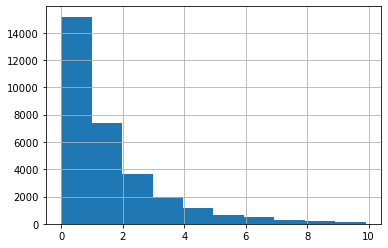

In [27]:
print('  DATOS MENORES A  10  ')
_dataset[_dataset['dato']<10]['dato'].hist()

  DATOS MAYORES A  10  


<AxesSubplot:>

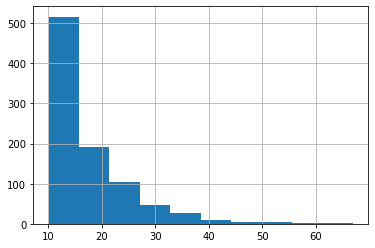

In [28]:
print('  DATOS MAYORES A  10  ')
_dataset[_dataset['dato']>10]['dato'].hist()

In [29]:
print('           ESTADISCIAS\n')

print(f'Flags:      {_dataset["flag"].unique()}')
print(f'Estaciones: {len(_dataset["codigo"].unique())}')
print(f'Totales:    {_dataset["dato"].count()}')
print(f'Atipicos:   {_dataset[_dataset["umbral"]==1]["dato"].count()}')
print(f'Ceros:      {_dataset[_dataset["dato"]==0]["dato"].count()}')

           ESTADISCIAS

Flags:      ['C0000001' 'C0000002']
Estaciones: 171
Totales:    32184
Atipicos:   6753
Ceros:      6114


In [30]:
"""
# Definimos las varibles para las iteraciones
Los parametros que van a cambiar son:
- Canales (products)
- Tiempos (Min de las imagenes)
- margen
"""
params = {'inputs'   : ['imagen'],#,'99%', 'altura'],
          'outputs'  : 'dato',  #umbral o dato
          'lr'       : 0.001,
          'batch'    : 32,        
          'dataset'  : 1,
          'epocas'   : 10,          
          'paciencia': 4,
          'canales'  : [3,3,3,3,3,3],
          'tiempos'  : [1,3,1,3,1,3],
          'margen'   : [50,50,110,110,70,70],
          'runs'     : 6
         }

In [38]:
%%time
#Solo imagenes (dato)
resultados = trainModel(params,_dataset,path_imagenes,path_base,products,times, graficos=1)

--------------------------------------------------
Inicio de la prueba N°: 1/6
Creadno modelo con input (50,50,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.1770 - mse: 11.1770
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220413_221637.hdf5
804/804 [==============================] - 417s 510ms/step - loss: 11.1770 - mse: 11.1770 - val_loss: 11.1782 - val_mse: 11.1782 - _timestamp: 1649906624.0000 - _runtime: 427.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.0764 - mse: 11.0764
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220413_221637.hdf5
804/804 [==============================] - 434s 540ms/step - loss: 11.0764 - mse: 11.0764 - val_loss: 11.0365 - val_mse: 11.0365 - _timestamp: 1649907057.0000 - _runtime: 860.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.0400 - mse: 11.0400
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220413_221637.hdf5
8

epoch,▁▃▅▆█
loss,█▃▁▁▁
mse,█▃▁▁▁
val_loss,█▂▁▁▁
val_mse,█▂▁▁▁
best_epoch,4
best_val_loss,11.01899
epoch,4
loss,11.03021
mse,11.03021
val_loss,11.01899


--------------------------------------------------
Inicio de la prueba N°: 2/6
Creadno modelo con input (50,50,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.5162 - mse: 11.5162
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220413_225236.hdf5
804/804 [==============================] - 1269s 2s/step - loss: 11.5162 - mse: 11.5162 - val_loss: 11.4565 - val_mse: 11.4565 - _timestamp: 1649909638.0000 - _runtime: 1281.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.4248 - mse: 11.4248
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220413_225236.hdf5
804/804 [==============================] - 1413s 2s/step - loss: 11.4248 - mse: 11.4248 - val_loss: 11.4428 - val_mse: 11.4428 - _timestamp: 1649911051.0000 - _runtime: 2694.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.4188 - mse: 11.4188
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220413_225236.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▂▂▂▁
val_mse,█▂▂▂▁
best_epoch,4
best_val_loss,11.44086
epoch,4
loss,11.41285
mse,11.41285
val_loss,11.44086


--------------------------------------------------
Inicio de la prueba N°: 3/6
Creadno modelo con input (110,110,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.5810 - mse: 11.5810
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_002806.hdf5
804/804 [==============================] - 366s 451ms/step - loss: 11.5810 - mse: 11.5810 - val_loss: 11.6146 - val_mse: 11.6146 - _timestamp: 1649914469.0000 - _runtime: 383.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.4577 - mse: 11.4577
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_002806.hdf5
804/804 [==============================] - 292s 363ms/step - loss: 11.4577 - mse: 11.4577 - val_loss: 11.5318 - val_mse: 11.5318 - _timestamp: 1649914761.0000 - _runtime: 675.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.4479 - mse: 11.4479
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_002806.hdf5
8

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▅▂▄▁
val_mse,█▅▂▄▁
best_epoch,4
best_val_loss,11.43953
epoch,4
loss,11.43909
mse,11.43909
val_loss,11.43953


--------------------------------------------------
Inicio de la prueba N°: 4/6
Creadno modelo con input (110,110,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.7266 - mse: 11.7266
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_115840.hdf5
804/804 [==============================] - 1395s 2s/step - loss: 11.7266 - mse: 11.7266 - val_loss: 11.6761 - val_mse: 11.6761 - _timestamp: 1649956927.0000 - _runtime: 1406.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.5876 - mse: 11.5876
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_115840.hdf5
804/804 [==============================] - 1033s 1s/step - loss: 11.5876 - mse: 11.5876 - val_loss: 11.5738 - val_mse: 11.5738 - _timestamp: 1649957960.0000 - _runtime: 2439.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.5804 - mse: 11.5804
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_115840.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▂▁▁▁
val_mse,█▂▁▁▁
best_epoch,4
best_val_loss,11.55415
epoch,4
loss,11.57224
mse,11.57224
val_loss,11.55415


--------------------------------------------------
Inicio de la prueba N°: 5/6
Creadno modelo con input (70,70,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.1659 - mse: 11.1659
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_133141.hdf5
804/804 [==============================] - 482s 600ms/step - loss: 11.1659 - mse: 11.1659 - val_loss: 11.4049 - val_mse: 11.4049 - _timestamp: 1649961601.0000 - _runtime: 499.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.0545 - mse: 11.0545
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_133141.hdf5
804/804 [==============================] - 420s 523ms/step - loss: 11.0545 - mse: 11.0545 - val_loss: 11.0362 - val_mse: 11.0362 - _timestamp: 1649962021.0000 - _runtime: 919.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.0207 - mse: 11.0207
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_133141.hdf5
8

epoch,▁▃▅▆█
loss,█▃▁▁▁
mse,█▃▁▁▁
val_loss,█▂▁▁▁
val_mse,█▂▁▁▁
best_epoch,4
best_val_loss,11.00288
epoch,4
loss,11.01717
mse,11.01717
val_loss,11.00288


--------------------------------------------------
Inicio de la prueba N°: 6/6
Creadno modelo con input (70,70,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.5729 - mse: 11.5729
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_144618.hdf5
804/804 [==============================] - 910s 1s/step - loss: 11.5729 - mse: 11.5729 - val_loss: 11.4863 - val_mse: 11.4863 - _timestamp: 1649966502.0000 - _runtime: 923.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.4477 - mse: 11.4477
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_144618.hdf5
804/804 [==============================] - 908s 1s/step - loss: 11.4477 - mse: 11.4477 - val_loss: 11.4842 - val_mse: 11.4842 - _timestamp: 1649967410.0000 - _runtime: 1831.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.4371 - mse: 11.4371
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_144618.hdf5
804/80

epoch,▁▃▅▆█
loss,█▂▂▁▁
mse,█▂▂▁▁
val_loss,█▇█▄▁
val_mse,█▇█▄▁
best_epoch,4
best_val_loss,11.46046
epoch,4
loss,11.42641
mse,11.42641
val_loss,11.46046


CPU times: total: 2d 4h 13min 10s
Wall time: 17h 58min 7s


In [39]:
"""
# Definimos las varibles para las iteraciones
Los parametros que van a cambiar son:
- Canales (products)
- Tiempos (Min de las imagenes)
- margen
"""
params = {'inputs'   : ['imagen'],#,'99%', 'altura'],
          'outputs'  : 'dato',  #umbral o dato
          'lr'       : 0.001,
          'batch'    : 32,        
          'dataset'  : 1,
          'epocas'   : 10,          
          'paciencia': 4,
          'canales'  : [3,3,3,3,3,3],
          'tiempos'  : [4,6,4,6,4,6],
          'margen'   : [50,50,110,110,70,70],
          'runs'     : 6
         }

In [40]:
%%time
#Solo imagenes (dato)
resultados = trainModel(params,_dataset,path_imagenes,path_base,products,times, graficos=1)

--------------------------------------------------
Inicio de la prueba N°: 1/6
Creadno modelo con input (50,50,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.5329 - mse: 11.5329
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_161445.hdf5
804/804 [==============================] - 1217s 2s/step - loss: 11.5329 - mse: 11.5329 - val_loss: 11.3075 - val_mse: 11.3075 - _timestamp: 1649972112.0000 - _runtime: 1227.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.3417 - mse: 11.3417
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_161445.hdf5
804/804 [==============================] - 1217s 2s/step - loss: 11.3417 - mse: 11.3417 - val_loss: 11.3403 - val_mse: 11.3403 - _timestamp: 1649973329.0000 - _runtime: 2444.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.3046 - mse: 11.3046
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_161445.hdf5
804

epoch,▁▂▄▅▇█
loss,█▂▁▁▁▁
mse,█▂▁▁▁▁
val_loss,▁█▄▂▃▁
val_mse,▁█▄▂▃▁
best_epoch,0
best_val_loss,11.30751
epoch,5
loss,11.29903
mse,11.29903
val_loss,11.30897


--------------------------------------------------
Inicio de la prueba N°: 2/6
Creadno modelo con input (50,50,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.6859 - mse: 11.6859
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_183450.hdf5
804/804 [==============================] - 1960s 2s/step - loss: 11.6859 - mse: 11.6859 - val_loss: 11.4979 - val_mse: 11.4979 - _timestamp: 1649981270.0000 - _runtime: 1980.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.5228 - mse: 11.5228
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_183450.hdf5
804/804 [==============================] - 2091s 3s/step - loss: 11.5228 - mse: 11.5228 - val_loss: 11.4913 - val_mse: 11.4913 - _timestamp: 1649983361.0000 - _runtime: 4071.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.5127 - mse: 11.5127
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_183450.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▁▁▁▁
val_mse,█▁▁▁▁
best_epoch,3
best_val_loss,11.49116
epoch,4
loss,11.50559
mse,11.50559
val_loss,11.49142


--------------------------------------------------
Inicio de la prueba N°: 3/6
Creadno modelo con input (110,110,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.8819 - mse: 11.8819
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_212623.hdf5
804/804 [==============================] - 1366s 2s/step - loss: 11.8819 - mse: 11.8819 - val_loss: 11.8189 - val_mse: 11.8189 - _timestamp: 1649990968.0000 - _runtime: 1385.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.7621 - mse: 11.7621
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_212623.hdf5
804/804 [==============================] - 1210s 2s/step - loss: 11.7621 - mse: 11.7621 - val_loss: 11.7588 - val_mse: 11.7588 - _timestamp: 1649992178.0000 - _runtime: 2595.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.7537 - mse: 11.7537
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220414_212623.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▃▂▁▁
val_mse,█▃▂▁▁
best_epoch,4
best_val_loss,11.73322
epoch,4
loss,11.74644
mse,11.74644
val_loss,11.73322


--------------------------------------------------
Inicio de la prueba N°: 4/6
Creadno modelo con input (110,110,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.6637 - mse: 11.6637
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_094229.hdf5
804/804 [==============================] - 2404s 3s/step - loss: 11.6637 - mse: 11.6637 - val_loss: 11.5602 - val_mse: 11.5602 - _timestamp: 1650036171.0000 - _runtime: 2422.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.5347 - mse: 11.5347
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_094229.hdf5
804/804 [==============================] - 1997s 2s/step - loss: 11.5347 - mse: 11.5347 - val_loss: 11.5165 - val_mse: 11.5165 - _timestamp: 1650038169.0000 - _runtime: 4420.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.5286 - mse: 11.5286
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_094229.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▂▁▁▁
val_mse,█▂▁▁▁
best_epoch,4
best_val_loss,11.50844
epoch,4
loss,11.52286
mse,11.52286
val_loss,11.50844


--------------------------------------------------
Inicio de la prueba N°: 5/6
Creadno modelo con input (70,70,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 12.0984 - mse: 12.0984
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_130931.hdf5
804/804 [==============================] - 2009s 2s/step - loss: 12.0984 - mse: 12.0984 - val_loss: 11.9842 - val_mse: 11.9842 - _timestamp: 1650048196.0000 - _runtime: 2024.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.9836 - mse: 11.9836
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_130931.hdf5
804/804 [==============================] - 1868s 2s/step - loss: 11.9836 - mse: 11.9836 - val_loss: 11.9609 - val_mse: 11.9609 - _timestamp: 1650050064.0000 - _runtime: 3892.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.9784 - mse: 11.9784
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_130931.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▁▁▁▂
val_mse,█▁▁▁▂
best_epoch,2
best_val_loss,11.95962
epoch,4
loss,11.97225
mse,11.97225
val_loss,11.96268


--------------------------------------------------
Inicio de la prueba N°: 6/6
Creadno modelo con input (70,70,3)) tipo (dato)
DONE
Tamaño del dataset: Train 25716  - Val 6430
- Batch size:  32


Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 11.3143 - mse: 11.3143
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_153352.hdf5
804/804 [==============================] - 2163s 3s/step - loss: 11.3143 - mse: 11.3143 - val_loss: 11.4147 - val_mse: 11.4147 - _timestamp: 1650057013.0000 - _runtime: 2181.0000
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 11.1840 - mse: 11.1840
Epoch 2: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_153352.hdf5
804/804 [==============================] - 2316s 3s/step - loss: 11.1840 - mse: 11.1840 - val_loss: 11.2352 - val_mse: 11.2352 - _timestamp: 1650059329.0000 - _runtime: 4497.0000
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 11.1662 - mse: 11.1662
Epoch 3: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_153352.hdf5
804

epoch,▁▃▅▆█
loss,█▂▁▁▁
mse,█▂▁▁▁
val_loss,█▂▂▂▁
val_mse,█▂▂▂▁
best_epoch,4
best_val_loss,11.21093
epoch,4
loss,11.16194
mse,11.16194
val_loss,11.21093


CPU times: total: 5d 11h 46min 4s
Wall time: 1d 2h 29min 57s
